# **Insights into Urban Dynamics:** Analyzing Airbnb Reviews and Neighborhood Metrics
---
### Project Overview

This study aims to investigate the correlation between subjective Airbnb reviews and objective neighborhood metrics in select US cities. It involves analyzing crime statistics, demographics, socioeconomic indicators, and environmental quality to understand how they relate to sentiments expressed in Airbnb reviews.

---
### Objectives

- Investigate correlations between subjective reviews and quantifiable neighborhood attributes in targeted US cities.
- Understand how guest experiences align with tangible neighborhood characteristics.
---
### Methodologies and Tools

- **Data Collection**: Utilize Python libraries (e.g., Pandas, Requests) for data collection and preprocessing.
- **Sentiment Analysis**: Implement TextBlob for sentiment analysis of Airbnb reviews and consider numerical ratings.
- **Correlation Techniques**: Employ regression analysis, correlation coefficients and other analysis techniques(cluster, principle component, etc.)
- **Visualization**: Use Matplotlib or Plotly or Seaborn for visual representation of relationships.
---
### Data Sources
We extracted data from: 
- Inside Airbnb 
http://insideairbnb.com/get-the-data/
- Cost of Living
https://www.kaggle.com/code/eugeniokukes/us-cost-of-living/notebook
- EPA

---

# **Data Preprocessing**

### Import dependencies

In [2]:
!pip install seaborn matplotlib
!pip install scikit-learn
!pip install textblob
!python -m textblob.download_corpora
!pip install geopandas

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\12039\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

In [3]:
import pandas as pd
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
import zipfile
import geopandas as gpd
import glob

## **Location specific data**

### Pull and clean cost of living file -- **HAVING A LOT OF TROUBLE MAPPING TO LISTING FILE**

In [39]:
cost_of_living = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/cost_of_living_us.csv')
cost_of_living.head()

case_id state  isMetro            areaname          county  \
0        1    AL     True  Montgomery, AL MSA  Autauga County   
1        1    AL     True  Montgomery, AL MSA  Autauga County   
2        1    AL     True  Montgomery, AL MSA  Autauga County   
3        1    AL     True  Montgomery, AL MSA  Autauga County   
4        1    AL     True  Montgomery, AL MSA  Autauga County   

  family_member_count  housing_cost    food_cost  transportation_cost  \
0                1p0c    8505.72876   3454.91712          10829.16876   
1                1p1c   12067.50240   5091.70788          11588.19288   
2                1p2c   12067.50240   7460.20308          12361.77720   
3                1p3c   15257.15040   9952.23924          13452.18600   
4                1p4c   15257.15040  12182.21400          13744.59840   

   healthcare_cost  other_necessities_cost  childcare_cost        taxes  \
0       5737.47984              4333.81344          0.0000   6392.94504   
1       8659.55640              6217.45896       6147.8298   7422.07836   
2      11581.63260              7075.65816      15824.6940   9769.56228   
3      14503.70760              9134.35620      18802.1892  13101.70320   
4      17425.78560              9942.36396      18802.1892  13469.21880   

    total_cost  median_family_income  
0   39254.0532          73010.414062  
1   57194.3256          73010.414062  
2   76141.0308          73010.414062  
3   94203.5328          73010.414062  
4  100823.5200          73010.414062

In [4]:
cost_of_living.dtypes

case_id                     int64
state                      object
isMetro                      bool
areaname                   object
county                     object
family_member_count        object
housing_cost              float64
food_cost                 float64
transportation_cost       float64
healthcare_cost           float64
other_necessities_cost    float64
childcare_cost            float64
taxes                     float64
total_cost                float64
median_family_income      float64
dtype: object

In [5]:
cost_of_living.family_member_count.unique()

array(['1p0c', '1p1c', '1p2c', '1p3c', '1p4c', '2p0c', '2p1c', '2p2c',
       '2p3c', '2p4c'], dtype=object)

In [ ]:
cost_of_living[['adult_count', 'child_count']] = cost_of_living['family_member_count'].str.extract(r'(\d+)p(\d+)c').astype(int)
cost_of_living.head()

In [ ]:
cost_of_living['state'] = cost_of_living['areaname'].str.extract(r',\s*([A-Z]{2})\s+MSA', expand=False)
cost_of_living.head()

In [ ]:
cost_of_living['county_state'] = cost_of_living['county'] + ', ' + cost_of_living['state']
cost_of_living.head()

In [ ]:
# Check for null values
null_values = cost_of_living.isnull().sum()

# Check for zeros
zero_values = (cost_of_living == 0).sum()

# Display the count of null and zero values
print("Null Values:")
print(null_values)

print("\nZero Values:")
print(zero_values)

In [ ]:
# Calculate averages by 'areaname'
averages_by_area = cost_of_living.groupby('areaname').mean()

# Display the averages
averages_by_area

In [82]:
#create csv file with cost of living data for each arename
averages_by_area.to_csv('avg_cost_of_living_by_area',index=False)

# Extracting unique index values ('areaname')
unique_areanames = averages_by_area.index.unique()

# Creating a DataFrame with unique 'areaname' values
unique_cost_areanames = pd.DataFrame({'areaname': unique_areanames})

# Save the DataFrame to a CSV file without an index
unique_cost_areanames.to_csv('unique_cost_areanames.csv', index=False)

unique_cost_areanames.head()

areaname
0                  Abbeville County, SC
1                       Abilene, TX MSA
2  Acadia Parish, LA HUD Metro FMR Area
3                   Accomack County, VA
4                      Adair County, IA

### Pull and Clean Air Quality File

In [386]:
air_quality = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/air_quality_2023.csv')
air_quality.head()

CBSA  CBSA Code  Year  Days with AQI  Good Days  Moderate Days  \
0  Aberdeen, SD      10100  2023            181        161             17   
1  Aberdeen, WA      10140  2023            181        181              0   
2       Ada, OK      10220  2023            181        148             33   
3    Adrian, MI      10300  2023            180        102             64   
4     Akron, OH      10420  2023            243        153             81   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  \
0                                    2               1                    0   
1                                    0               0                    0   
2                                    0               0                    0   
3                                    9               4                    1   
4                                    6               2                    1   

   Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO  \
0               0      162                   52          23        0   
1               0       40                   28          15        0   
2               0       93                   56          39        0   
3               0      229                   90          49        0   
4               0      205                   80          45        0   

   Days NO2  Days Ozone  Days PM2.5  Days PM10  
0         0           0         144         37  
1         0           0         181          0  
2         0         154          22          5  
3         0          75         105          0  
4         0         156          87          0

In [387]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   CBSA                                 488 non-null    object
 1   CBSA Code                            488 non-null    int64 
 2   Year                                 488 non-null    int64 
 3   Days with AQI                        488 non-null    int64 
 4   Good Days                            488 non-null    int64 
 5   Moderate Days                        488 non-null    int64 
 6   Unhealthy for Sensitive Groups Days  488 non-null    int64 
 7   Unhealthy Days                       488 non-null    int64 
 8   Very Unhealthy Days                  488 non-null    int64 
 9   Hazardous Days                       488 non-null    int64 
 10  Max AQI                              488 non-null    int64 
 11  90th Percentile AQI                  488 non-

### Pull and Clean Crime Data -- DOESN'T HAVE SEATTLE!!

In [307]:
!pip install xlrd

     -------------------------------------- 96.5/96.5 kB 784.5 kB/s eta 0:00:00


In [ ]:
# Replace 'file_path.xlsx' with the path to your Excel file
file_path = 'C:\\Users\\12039\\Downloads\\table-6.xls'

# Load the Excel file into a DataFrame
data = pd.read_excel(file_path, header=3)# header = 3 drops the first rows with table names

# Display the first few rows of the DataFrame
print(data.head())

In [347]:
# Forward-fill NaN values in the 'Metropolitan Statistical Area' column
data['Metropolitan Statistical Area'].fillna(method='ffill', inplace=True)

# Filter 'Counties/principal cities' column to only rows containing 'City of'
filtered_data = data[data['Counties/principal cities'].str.contains('City of', na=False)]

# Display the filtered DataFrame
filtered_data.head()

Metropolitan Statistical Area Counties/principal cities Population  \
2             Abilene, TX M.S.A.           City of Abilene     123665   
7              Akron, OH M.S.A.2             City of Akron     197882   
13            Albany, GA M.S.A.3           City of Albany3      74989   
19     Albany-Lebanon, OR M.S.A.            City of Albany      54993   
20     Albany-Lebanon, OR M.S.A.           City of Lebanon      17304   

   Violent\ncrime Murder and\nnonnegligent\nmanslaughter  Rape1  Robbery  \
2             458                                      6   87.0     68.0   
7            1782                                     27  181.0    328.0   
13            790                                     12   32.0    165.0   
19             70                                      1   10.0     16.0   
20             29                                      0   11.0      0.0   

   Aggravated\nassault Property\ncrime  Burglary  Larceny-\ntheft  \
2                  297            3112     576.0           2330.0   
7                 1246            6568    1686.0           4305.0   
13                 581            3452     729.0           2489.0   
19                  43            1467     128.0           1242.0   
20                  18             372      22.0            323.0   

    Motor\nvehicle\ntheft  
2                   206.0  
7                   577.0  
13                  234.0  
19                   97.0  
20                   27.0

In [348]:
filtered_data.dtypes

Metropolitan Statistical Area              object
Counties/principal cities                  object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter     object
Rape1                                     float64
Robbery                                   float64
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
dtype: object

In [349]:
columns_to_convert = [
    'Population',
    'Violent\ncrime',
    'Murder and\nnonnegligent\nmanslaughter',
    'Aggravated\nassault',
    'Property\ncrime'
]

filtered_data = filtered_data.copy()
filtered_data[columns_to_convert] = filtered_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

filtered_data.dtypes

Metropolitan Statistical Area              object
Counties/principal cities                  object
Population                                  int64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape1                                     float64
Robbery                                   float64
Aggravated\nassault                         int64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
dtype: object

In [350]:
filtered_data['violent_rate'] = filtered_data['Violent\ncrime'].astype(float) / filtered_data['Population'].astype(float) * 1000
filtered_data['murder_rate'] = filtered_data['Murder and\nnonnegligent\nmanslaughter'].astype(float) / filtered_data['Population'].astype(float) * 1000
filtered_data['property_crime_rate'] = filtered_data['Property\ncrime'].astype(float) / filtered_data['Population'].astype(float) * 1000
filtered_data['theft_rate'] = filtered_data['Larceny-\ntheft'].astype(float) / filtered_data['Population'].astype(float) * 1000

filtered_data.head()

Metropolitan Statistical Area Counties/principal cities  Population  \
2             Abilene, TX M.S.A.           City of Abilene      123665   
7              Akron, OH M.S.A.2             City of Akron      197882   
13            Albany, GA M.S.A.3           City of Albany3       74989   
19     Albany-Lebanon, OR M.S.A.            City of Albany       54993   
20     Albany-Lebanon, OR M.S.A.           City of Lebanon       17304   

    Violent\ncrime  Murder and\nnonnegligent\nmanslaughter  Rape1  Robbery  \
2            458.0                                     6.0   87.0     68.0   
7           1782.0                                    27.0  181.0    328.0   
13           790.0                                    12.0   32.0    165.0   
19            70.0                                     1.0   10.0     16.0   
20            29.0                                     0.0   11.0      0.0   

    Aggravated\nassault  Property\ncrime  Burglary  Larceny-\ntheft  \
2                   297           3112.0     576.0           2330.0   
7                  1246           6568.0    1686.0           4305.0   
13                  581           3452.0     729.0           2489.0   
19                   43           1467.0     128.0           1242.0   
20                   18            372.0      22.0            323.0   

    Motor\nvehicle\ntheft  violent_rate  murder_rate  property_crime_rate  \
2                   206.0      3.703554     0.048518            25.164760   
7                   577.0      9.005367     0.136445            33.191498   
13                  234.0     10.534878     0.160023            46.033418   
19                   97.0      1.272889     0.018184            26.676122   
20                   27.0      1.675913     0.000000            21.497920   

    theft_rate  
2    18.841224  
7    21.755390  
13   33.191535  
19   22.584693  
20   18.666204

### Oh no!!  It doesn't have Seattle in it!!!

In [ ]:
seattle_crime = filtered_data[filtered_data['Metropolitan Statistical Area'].str.contains('WA', na=False)]
print(seattle_crime)

In [ ]:
url = 'https://gist.githubusercontent.com/bradoyler/5adf1567be59283d3e882035e0371ed1/raw/093af42971ddc3000712752c5f7709fec1dd121f/crime-in-us-2015.csv'


## **Airbnb listings**

### Examine dfs

In [61]:
seattle_listings = pd.read_csv('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz')

In [65]:
seattle_listings['neighbourhood'].unique()

array(['Seattle, Washington, United States', nan,
       'Ballard, Seattle, Washington, United States',
       'West Seattle, Washington, United States',
       'Ballard Seattle, Washington, United States',
       'Capitol Hill, Seattle, Washington, United States',
       'Seattle, United States',
       'West Seattle, Washington, Washington, United States',
       'Seattle, Wa, United States',
       'Shoreline, Washington, United States',
       'Seattle , Washington, United States',
       'Lake Forest Park, Washington, United States'], dtype=object)

In [66]:
oakland_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/listings.csv.gz')
oakland_listings['neighbourhood'].unique()

array(['Oakland, California, United States', nan,
       'Berkeley, California, United States',
       'Piedmont, California, United States',
       'Emeryville, California, United States'], dtype=object)

In [ ]:
la_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/listings.csv.gz')
oakland_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/listings.csv.gz')
boston_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2023-09-16/data/listings.csv.gz')
nyc_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/listings.csv.gz')
new_orleans_listings = pd.read_csv('http://data.insideairbnb.com/united-states/la/new-orleans/2023-09-03/data/listings.csv.gz')
austin_listings = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/listings.csv.gz')
chicago_listings = pd.read_csv('http://data.insideairbnb.com/united-states/il/chicago/2023-09-12/data/listings.csv.gz')
nashville_listings = pd.read_csv('http://data.insideairbnb.com/united-states/tn/nashville/2023-09-16/data/listings.csv.gz')

### Create large df that includes all 9 cities sets

In [89]:
# Read location info and listings CSV files into pandas DataFrames
seattle_listings = pd.read_csv('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz')
la_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/listings.csv.gz')
oakland_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/listings.csv.gz')
boston_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ma/boston/2023-09-16/data/listings.csv.gz')
nyc_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/listings.csv.gz')
new_orleans_listings = pd.read_csv('http://data.insideairbnb.com/united-states/la/new-orleans/2023-09-03/data/listings.csv.gz')
austin_listings = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/listings.csv.gz')
chicago_listings = pd.read_csv('http://data.insideairbnb.com/united-states/il/chicago/2023-09-12/data/listings.csv.gz')
nashville_listings = pd.read_csv('http://data.insideairbnb.com/united-states/tn/nashville/2023-09-16/data/listings.csv.gz')

def concatenate_listings_dataframes(*dfs):
    concatenated_df = pd.concat(dfs, ignore_index=True)
    return concatenated_df
all_listings = concatenate_listings_dataframes(seattle_listings, la_listings, oakland_listings, boston_listings, nyc_listings, new_orleans_listings, austin_listings, chicago_listings, nashville_listings)


### Clean Airbnb listing dataframe and save cleaned_listings dataframe as .csv

In [90]:
all_listings.head()

id                        listing_url       scrape_id last_scraped  \
0  6606  https://www.airbnb.com/rooms/6606  20230918050357   2023-09-18   
1  9419  https://www.airbnb.com/rooms/9419  20230918050357   2023-09-18   
2  9531  https://www.airbnb.com/rooms/9531  20230918050357   2023-09-18   
3  9534  https://www.airbnb.com/rooms/9534  20230918050357   2023-09-18   
4  9596  https://www.airbnb.com/rooms/9596  20230918050357   2023-09-18   

            source                                               name  \
0      city scrape  Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...   
1      city scrape  Rental unit in Seattle · ★4.72 · 1 bedroom · 1...   
2      city scrape  Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...   
3      city scrape  Guest suite in Seattle · ★4.99 · 2 bedrooms · ...   
4  previous scrape  Rental unit in Seattle · ★4.56 · 1 bedroom · 4...   

                                         description  \
0  This tiny cottage is only 15x10, but it has ev...   
1  Keeping you safe is our priority, we are adher...   
2  The Sweet Orange is a delightful and spacious ...   
3  Welcome to my delicious Tangerine Dream!  A co...   
4  We are in a great neighborhood, quiet, full of...   

                               neighborhood_overview  \
0  A peaceful yet highly accessible neighborhood,...   
1  Lots of restaurants (see our guide book) bars,...   
2  The neighborhood is awesome!  Just far enough ...   
3  The neighborhood is the best of two worlds...w...   
4  if you arrive early for check in at 3,  I reco...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/45742/21116d7...    14942  ...   
1  https://a0.muscache.com/pictures/56645186/e5fb...    30559  ...   
2  https://a0.muscache.com/pictures/30470355/052c...    31481  ...   
3  https://a0.muscache.com/pictures/30476721/0751...    31481  ...   
4  https://a0.muscache.com/pictures/665252/102d18...    14942  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.76                   4.88                4.57   
1                        4.89                   4.66                4.65   
2                        4.96                   4.97                4.91   
3                        4.99                   4.96                4.95   
4                        4.66                   4.91                4.56   

               license instant_bookable calculated_host_listings_count  \
0   str-opli-19-002622                f                              2   
1   STR-OPLI-19-003039                f                              9   
2   STR-OPLI-19-002182                f                              2   
3   STR-OPLI-19-002182                f                              2   
4  STR -OPLI-19-002622                f                              2   

  calculated_host_listings_count_entire_homes  \
0                                           2   
1                                           0   
2                                           2   
3                                           2   
4                                           2   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            9   
2                                            0   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.93  
1                                           0              1.21  
2                                           0              0.54  
3                                           0              0.53  
4                                           0              0.65  

[5 rows x 75 columns]

In [ ]:
all_listings.info()

In [91]:
#Check for null values in the listing dataset
null_percentage = (all_listings.isna().mean() * 100).round(2).sort_values(ascending=False)
print(null_percentage)

bathrooms                 100.00
calendar_updated          100.00
license                    73.32
host_about                 40.54
neighborhood_overview      38.67
                           ...  
minimum_maximum_nights      0.00
minimum_nights_avg_ntm      0.00
maximum_nights_avg_ntm      0.00
has_availability            0.00
id                          0.00
Length: 75, dtype: float64


In [92]:
def clean_listings_file(df, columns_to_drop=None):
    # Drop columns with >50% NA
    threshold = len(df) * 0.5  # 50% threshold
    df = df.dropna(thresh=threshold, axis=1)

    # Identify columns containing 'host' in their names
    host_columns = [col for col in df.columns if 'host' in col]

    # Initialize cols_to_drop if not provided
    if columns_to_drop is None:
        columns_to_drop = []

    # Combine all columns to drop
    cols_to_drop = columns_to_drop + host_columns

    # Filter the columns that actually exist in the DataFrame
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]

    # Drop columns with 'availability' in the column name
    availability_columns = df.filter(like='availability').columns.tolist()
    cols_to_drop += availability_columns

    # Drop columns from the DataFrame
    df = df.drop(cols_to_drop, axis=1)
    
    return df



specified_columns = [
    'listing_url', 'scrape_id', 'source',
     'picture_url','license', 'amenities'
]

cleaned_all_listings = clean_listings_file(all_listings.copy(), specified_columns)


In [93]:
cleaned_all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136015 entries, 0 to 136014
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            136015 non-null  int64  
 1   last_scraped                  136015 non-null  object 
 2   name                          136015 non-null  object 
 3   description                   134567 non-null  object 
 4   neighborhood_overview         83424 non-null   object 
 5   neighbourhood                 83427 non-null   object 
 6   neighbourhood_cleansed        136015 non-null  object 
 7   neighbourhood_group_cleansed  90577 non-null   object 
 8   latitude                      136015 non-null  float64
 9   longitude                     136015 non-null  float64
 10  property_type                 136015 non-null  object 
 11  room_type                     136015 non-null  object 
 12  accommodates                  136015 non-nul

In [94]:
cleaned_all_listings['bathrooms_text'].unique()

array(['1 bath', '3 shared baths', '1.5 baths', '4 shared baths',
       '1 shared bath', '3 baths', '2 baths', '1 private bath',
       '2.5 baths', '1.5 shared baths', 'Shared half-bath',
       '2 shared baths', '3.5 baths', '4 baths', 'Half-bath',
       '2.5 shared baths', '3.5 shared baths', '0 shared baths',
       '4.5 baths', '16 shared baths', '0 baths', '6 baths',
       'Private half-bath', '6.5 baths', '7 baths', '5.5 baths',
       '5 baths', '10 baths', nan, '8 baths', '9.5 baths', '9 baths',
       '5 shared baths', '11 shared baths', '7.5 baths', '8.5 baths',
       '13.5 baths', '8 shared baths', '27 baths', '8.5 shared baths',
       '11.5 shared baths', '7 shared baths', '12 baths', '24 baths',
       '4.5 shared baths', '11 baths', '11.5 baths', '15 baths',
       '6 shared baths', '14 shared baths', '16 baths', '10 shared baths',
       '10.5 baths', '21 baths', '17 baths', '36 baths',
       '5.5 shared baths', '12.5 baths', '13 baths', '25 baths',
       '9 shar

In [95]:
#create numerical column for # of bathrooms
def clean_text_values(value):
    if pd.isnull(value):
        return np.nan

    # Extract numerical values
    numeric_val = re.findall(r'\d+\.*\d*', str(value))
    
    # Return the first numerical value found (in case function is used on text that contains multiple)
    if numeric_val:
        return float(numeric_val[0])
    else:
        return np.nan

cleaned_all_listings['num_bathrooms'] = cleaned_all_listings['bathrooms_text'].apply(clean_text_values)
cleaned_all_listings.drop(columns='bathrooms_text', inplace=True)

In [99]:
#confrim removal of all null values
cleaned_all_listings.isna().any()

id                              False
last_scraped                    False
name                            False
description                      True
neighborhood_overview            True
neighbourhood                   False
neighbourhood_cleansed          False
neighbourhood_group_cleansed     True
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bedrooms                         True
beds                             True
price                           False
minimum_nights                  False
maximum_nights                  False
minimum_minimum_nights          False
maximum_minimum_nights          False
minimum_maximum_nights          False
maximum_maximum_nights          False
minimum_nights_avg_ntm          False
maximum_nights_avg_ntm          False
calendar_last_scraped           False
number_of_reviews               False
number_of_re

In [102]:
#clean 'instant_bookable' so it's not string
cleaned_all_listings['instant_bookable'].replace({'f': 0, 't': 1}, inplace=True)

In [103]:
# changing and converting data types for price
cleaned_all_listings['price'] = cleaned_all_listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [107]:
#remove listings with na
cleaned_all_listings.dropna(inplace=True)

In [108]:
cleaned_all_listings.head()

id last_scraped                                               name  \
0  6606   2023-09-18  Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...   
2  9531   2023-09-18  Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...   
3  9534   2023-09-18  Guest suite in Seattle · ★4.99 · 2 bedrooms · ...   
4  9596   2023-09-18  Rental unit in Seattle · ★4.56 · 1 bedroom · 4...   
5  9909   2023-09-18  Home in Seattle · ★4.80 · 2 bedrooms · 2 beds ...   

                                         description  \
0  This tiny cottage is only 15x10, but it has ev...   
2  The Sweet Orange is a delightful and spacious ...   
3  Welcome to my delicious Tangerine Dream!  A co...   
4  We are in a great neighborhood, quiet, full of...   
5  Our two-bedroom home is nestled in a quiet nei...   

                               neighborhood_overview  \
0  A peaceful yet highly accessible neighborhood,...   
2  The neighborhood is awesome!  Just far enough ...   
3  The neighborhood is the best of two worlds...w...   
4  if you arrive early for check in at 3,  I reco...   
5  The Luna Park neighborhood is located just a f...   

                        neighbourhood neighbourhood_cleansed  \
0  Seattle, Washington, United States            Wallingford   
2  Seattle, Washington, United States         Fairmount Park   
3  Seattle, Washington, United States         Fairmount Park   
4  Seattle, Washington, United States            Wallingford   
5  Seattle, Washington, United States         Fairmount Park   

  neighbourhood_group_cleansed  latitude  longitude  ... review_scores_rating  \
0          Other neighborhoods  47.65444 -122.33629  ...                 4.60   
2                 West Seattle  47.55495 -122.38663  ...                 4.96   
3                 West Seattle  47.55627 -122.38607  ...                 4.99   
4          Other neighborhoods  47.65608 -122.33602  ...                 4.56   
5                 West Seattle  47.56612 -122.37273  ...                 4.80   

  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                   4.67                       4.67                   4.83   
2                   4.99                       4.97                   4.99   
3                   4.99                       4.99                   5.00   
4                   4.55                       4.50                   4.80   
5                   4.88                       4.88                   4.94   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.76                    4.88                 4.57   
2                         4.96                    4.97                 4.91   
3                         4.99                    4.96                 4.95   
4                         4.66                    4.91                 4.56   
5                         4.94                    4.83                 4.82   

   instant_bookable  reviews_per_month  num_bathrooms  
0                 0               0.93            1.0  
2                 0               0.54            1.0  
3                 0               0.53            1.0  
4                 0               0.65            1.0  
5                 1               0.49            1.0  

[5 rows x 40 columns]

In [109]:
#recheck removal of all null values
cleaned_all_listings.isna().any()

id                              False
last_scraped                    False
name                            False
description                     False
neighborhood_overview           False
neighbourhood                   False
neighbourhood_cleansed          False
neighbourhood_group_cleansed    False
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bedrooms                        False
beds                            False
price                           False
minimum_nights                  False
maximum_nights                  False
minimum_minimum_nights          False
maximum_minimum_nights          False
minimum_maximum_nights          False
maximum_maximum_nights          False
minimum_nights_avg_ntm          False
maximum_nights_avg_ntm          False
calendar_last_scraped           False
number_of_reviews               False
number_of_re

In [110]:
cleaned_all_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27287 entries, 0 to 97150
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            27287 non-null  int64  
 1   last_scraped                  27287 non-null  object 
 2   name                          27287 non-null  object 
 3   description                   27287 non-null  object 
 4   neighborhood_overview         27287 non-null  object 
 5   neighbourhood                 27287 non-null  object 
 6   neighbourhood_cleansed        27287 non-null  object 
 7   neighbourhood_group_cleansed  27287 non-null  object 
 8   latitude                      27287 non-null  float64
 9   longitude                     27287 non-null  float64
 10  property_type                 27287 non-null  object 
 11  room_type                     27287 non-null  object 
 12  accommodates                  27287 non-null  int64  
 13  b

In [112]:
cleaned_all_listings.to_csv('cleaned_listings.csv', index=False)

## **Airbnb Detail Reviews**

### Create multi-city review dataframe from compressed .gz files and save as combined_reviews

In [ ]:
#DON'T USE THIS BECAUSE THE RESULTING DF IS TOO LARGE
#function that uses gzip to pull compressed file from url
'''import requests
import gzip
import io

def fetch_csv_gz_from_url(url):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            compressed_file = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_file, mode='rb') as gz_file:
                with io.TextIOWrapper(gz_file, encoding='utf-8') as file:
                    df = pd.read_csv(file)
            print("DataFrame created successfully")
            return df
        else:
            print("Failed to download the file")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
url = 'http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/reviews.csv.gz'
seattle_reviews = fetch_csv_gz_from_url(url)'''

### Create filtered review dataframes for 2022 and 2023 only (too large otherwise)

In [125]:
import requests
import io
import gzip
import pandas as pd


#function that uses gzip to pull compressed file from url, but you can filter based on the year of the 'date' column
def fetch_filtered_csv_gz_from_url(url, date_column, years):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            compressed_file = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_file, mode='rb') as gz_file:
                with io.TextIOWrapper(gz_file, encoding='utf-8') as file:
                    df = pd.read_csv(file)
            
            # Convert specified 'date_column' to datetime type
            df[date_column] = pd.to_datetime(df[date_column])
            
            # Filter rows based on the provided years in the specified 'date_column'
            filtered_df = df[df[date_column].dt.year.isin(years)]
            
            print(f"Filtered DataFrame for {years} created successfully based on '{date_column}' column")
            return filtered_df
        else:
            print("Failed to download the file")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

#create dfs for our project
target_years = [2022, 2023]  # List of years to filter
date_column_name = 'date'  #  date column name

seattle_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)
la_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)
oakland_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/oakland/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)
boston_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ma/boston/2023-09-16/data/reviews.csv.gz', date_column_name, target_years)
nyc_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/reviews.csv.gz', date_column_name, target_years)
neworleans_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/la/new-orleans/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)
austin_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/tx/austin/2023-09-10/data/reviews.csv.gz', date_column_name, target_years)
chicago_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/il/chicago/2023-09-12/data/reviews.csv.gz', date_column_name, target_years)
nashville_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/tn/nashville/2023-09-16/data/reviews.csv.gz', date_column_name, target_years)

combined_reviews = pd.concat([
    seattle_reviews_recent,
    la_reviews_recent,
    oakland_reviews_recent,
    boston_reviews_recent,
    nyc_reviews_recent,
    neworleans_recent,
    austin_recent,
    chicago_recent,
    nashville_reviews_recent
], ignore_index=True)

Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column
Filtered DataFrame for [2022, 2023] created successfully based on 'date' column


In [126]:
combined_reviews.head()

listing_id                  id       date  reviewer_id reviewer_name  \
0      353110  573999724723704695 2022-03-02    132891274          Nick   
1      353110  596369993109024929 2022-04-02    404948475         Genna   
2      353110  639180709801600503 2022-05-31    439438613       Lindsey   
3      353110  661713603181951779 2022-07-01     52541293      Jennifer   
4      353110  697957315562343313 2022-08-20    436930794        Ashley   

                                            comments  
0  Stayed for a month while relocating to Seattle...  
1  The West Seattle Backyard Cottage is in beauti...  
2  Location was fantastic! Eric was great and acc...  
3  My husband and I stayed at West Seattle Cottag...  
4  I stayed at the cottage for 7 weeks. It's in a...

### Apply TextBlob to calculate sentiment of the comments and create new column with results
**Note**: This can take some time since it calculates each row individually

In [ ]:
from textblob import TextBlob

#this can take a bit since TextBlob processes each text entry individually 
def add_sentiment_column(df):
    df['sentiment_score'] = df['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

add_sentiment_column(combined_reviews)

In [438]:
#Didn't save on GitHub because file is too large.  Used in the step below to create listings_with_sentiment
combined_reviews.to_csv('combined_reviews.csv', index=False)

## **Create listings_with_sentiment dataframe that combines cleaned_listings and combined_reviews**

### Add the avg sentiment rating to the listing df

In [444]:
average_sentiments = combined_reviews.groupby('listing_id')['sentiment_score'].mean().reset_index()

# Merge the averaged sentiment scores with the cleaned_all_listings DataFrame
merged_data = cleaned_all_listings.merge(average_sentiments, left_on='id', right_on='listing_id', how='left')

# Drop the redundant 'listing_id' column after merging
merged_data.drop('listing_id', axis=1, inplace=True)

merged_data.rename(columns={'sentiment_score': 'avg_sentiment'}, inplace=True)

merged_data.head()

id last_scraped                                               name  \
0  6606   2023-09-18  Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...   
1  9531   2023-09-18  Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...   
2  9534   2023-09-18  Guest suite in Seattle · ★4.99 · 2 bedrooms · ...   
3  9596   2023-09-18  Rental unit in Seattle · ★4.56 · 1 bedroom · 4...   
4  9909   2023-09-18  Home in Seattle · ★4.80 · 2 bedrooms · 2 beds ...   

                                         description  \
0  This tiny cottage is only 15x10, but it has ev...   
1  The Sweet Orange is a delightful and spacious ...   
2  Welcome to my delicious Tangerine Dream!  A co...   
3  We are in a great neighborhood, quiet, full of...   
4  Our two-bedroom home is nestled in a quiet nei...   

                               neighborhood_overview  \
0  A peaceful yet highly accessible neighborhood,...   
1  The neighborhood is awesome!  Just far enough ...   
2  The neighborhood is the best of two worlds...w...   
3  if you arrive early for check in at 3,  I reco...   
4  The Luna Park neighborhood is located just a f...   

                        neighbourhood neighbourhood_cleansed  \
0  Seattle, Washington, United States            Wallingford   
1  Seattle, Washington, United States         Fairmount Park   
2  Seattle, Washington, United States         Fairmount Park   
3  Seattle, Washington, United States            Wallingford   
4  Seattle, Washington, United States         Fairmount Park   

  neighbourhood_group_cleansed  latitude  longitude  ...  \
0          Other neighborhoods  47.65444 -122.33629  ...   
1                 West Seattle  47.55495 -122.38663  ...   
2                 West Seattle  47.55627 -122.38607  ...   
3          Other neighborhoods  47.65608 -122.33602  ...   
4                 West Seattle  47.56612 -122.37273  ...   

  review_scores_accuracy review_scores_cleanliness  review_scores_checkin  \
0                   4.67                      4.67                   4.83   
1                   4.99                      4.97                   4.99   
2                   4.99                      4.99                   5.00   
3                   4.55                      4.50                   4.80   
4                   4.88                      4.88                   4.94   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.76                    4.88                 4.57   
1                         4.96                    4.97                 4.91   
2                         4.99                    4.96                 4.95   
3                         4.66                    4.91                 4.56   
4                         4.94                    4.83                 4.82   

   instant_bookable  reviews_per_month  num_bathrooms  avg_sentiment  
0                 0               0.93            1.0       0.232675  
1                 0               0.54            1.0       0.458615  
2                 0               0.53            1.0       0.415740  
3                 0               0.65            1.0            NaN  
4                 1               0.49            1.0       0.353829  

[5 rows x 41 columns]

In [445]:
merged_data.to_csv('listings_with_sentiment.csv', index=False)

In [ ]:
cost_of_living_counts = cost_of_living['areaname'].unique().reset_index()
cost_of_living_counts.columns = ['AreaName', 'Count']
cost_of_living_counts.to_csv('cost_of_living_areas.csv', index=False)

In [67]:
#create list of unique neighbourhoods to map

# Load the CSV file into a DataFrame
listings_with_sentiment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/listings_with_sentiment.csv')

unique_neighbourhoods = pd.DataFrame({'Neighbourhood': listings_with_sentiment['neighbourhood'].unique()})
unique_neighbourhoods.to_csv('listings_with_sentiment_neighbourhoods.csv', index=False)


### Check for missing neighbourhoods, then remove those columns

In [88]:
listings_with_sentiment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/listings_with_sentiment.csv')
missing_neighbourhood_count = listings_with_sentiment['neighbourhood'].isna().sum()
missing_neighbourhood_count

0

In [ ]:
listings_with_sentiment['neighbourhood'].unique()

### Check sentiment score distribution

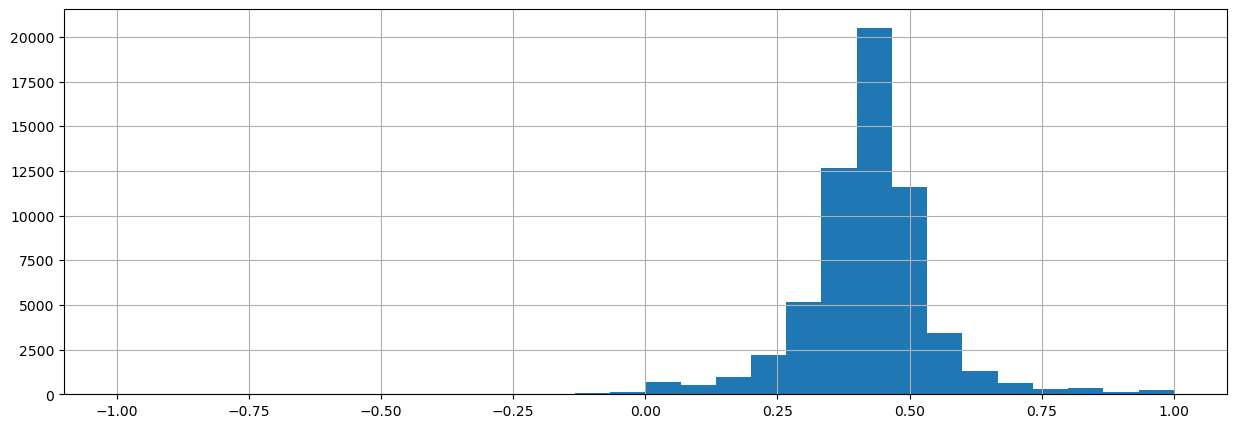

In [50]:
#check sentiment score distribution
listings_with_sentiment.avg_sentiment.hist(figsize=(15,5), bins=30);

## Still need to add columns for the location stats

### Need to link the following:

- **listings_with_sentiment** using the list of unique neighborhoods which has been exported to **listings_with_sentiment_unique**
- **avg_cost_of_living_by_area** using list of unique areanames in **unique_cost_areanames**

---
# **Exploratory Analysis**

## **Listings and Ratings**

In [5]:
listings_with_sentiment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/listings_with_sentiment.csv')
listings_with_sentiment.columns

Index(['id', 'last_scraped', 'name', 'description', 'neighborhood_overview',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'num_bathrooms', 'avg_sentiment'],
      dtype='object')

In [ ]:
!pip install folium

In [ ]:
# this crashed my computer
# import folium

# # Create a base map centered around the US
# map_us = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# # Iterate through each row in the DataFrame to add markers for each listing
# for index, row in listings_with_sentiment.iterrows():
#     popup_text = f"Listing ID: {row['id']}<br>Neighbourhood: {row['neighbourhood']}"
#     marker = folium.Marker([row['latitude'], row['longitude']], popup=popup_text)
#     marker.add_to(map_us)

# # Display the map
# map_us

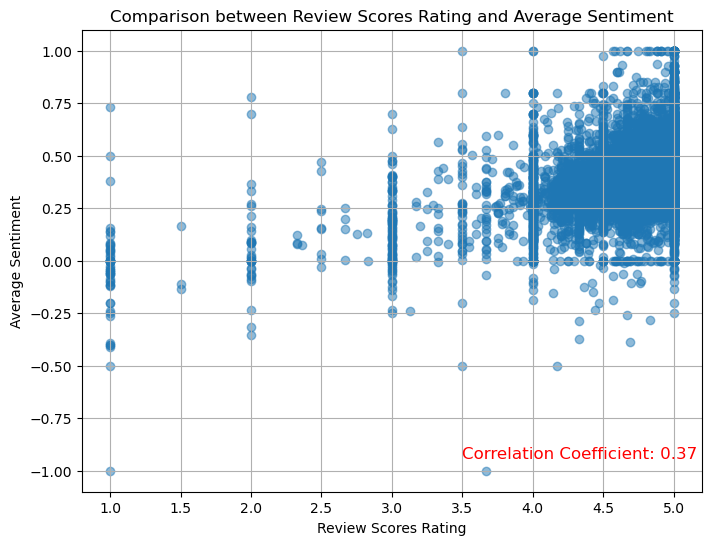

In [18]:
# Scatter plot to compare 'review_scores_rating' and 'avg_sentiment'

# Calculate the correlation coefficient
correlation_coefficient = listings_with_sentiment['review_scores_rating'].corr(listings_with_sentiment['avg_sentiment'])

plt.figure(figsize=(8, 6))
plt.scatter(listings_with_sentiment['review_scores_rating'], listings_with_sentiment['avg_sentiment'], alpha=0.5)
plt.xlabel('Review Scores Rating')
plt.ylabel('Average Sentiment')
plt.title('Comparison between Review Scores Rating and Average Sentiment')
plt.grid(True)
# Add the correlation coefficient to the plot as an annotation
# Add the correlation coefficient to the plot as an annotation
plt.annotate(f'Correlation Coefficient: {correlation_coefficient:.2f}', 
             xy=(listings_with_sentiment['review_scores_rating'].max() - 1.5 , 
                 listings_with_sentiment['avg_sentiment'].min() + 0.06),
             fontsize=12, color='red')
plt.show()

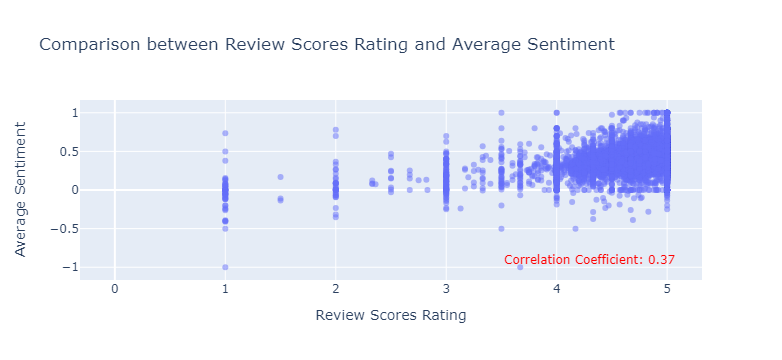

In [21]:
# same but using plotly

import plotly.graph_objects as go

# Calculate the correlation coefficient
correlation_coefficient = listings_with_sentiment['review_scores_rating'].corr(listings_with_sentiment['avg_sentiment'])

# Create a scatter plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=listings_with_sentiment['review_scores_rating'],
    y=listings_with_sentiment['avg_sentiment'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=listings_with_sentiment['review_scores_rating'].max() - .7,
    y=listings_with_sentiment['avg_sentiment'].min() + 0.1,
    text=f'Correlation Coefficient: {correlation_coefficient:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Review Scores Rating',
    yaxis_title='Average Sentiment',
    title='Comparison between Review Scores Rating and Average Sentiment'
)

fig.show()


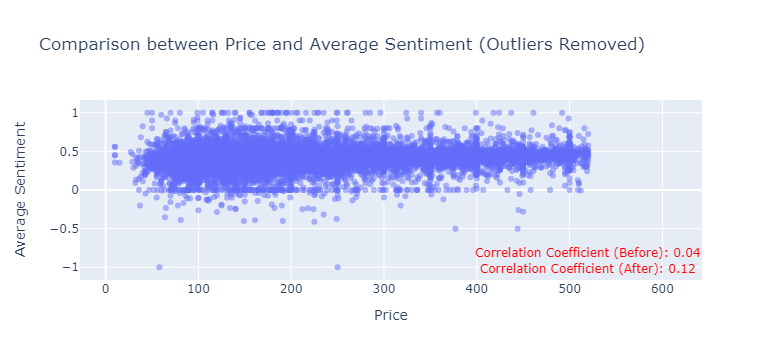

In [23]:
# Scatter plot to compare 'price' and 'avg_sentiment'

import plotly.graph_objects as go

# Calculate the correlation coefficient before removing outliers
correlation_before = listings_with_sentiment['price'].corr(listings_with_sentiment['avg_sentiment'])

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from 'price' column
listings_without_outliers = remove_outliers(listings_with_sentiment, 'price')

# Calculate the correlation coefficient after removing outliers
correlation_after = listings_without_outliers['price'].corr(listings_without_outliers['avg_sentiment'])

# Create a scatter plot using Plotly with outliers removed
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=listings_without_outliers['price'],
    y=listings_without_outliers['avg_sentiment'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=listings_without_outliers['price'].max() - .7,
    y=listings_without_outliers['avg_sentiment'].min() + 0.1,
    text=f'Correlation Coefficient (Before): {correlation_before:.2f}<br>Correlation Coefficient (After): {correlation_after:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Price',
    yaxis_title='Average Sentiment',
    title='Comparison between Price and Average Sentiment (Outliers Removed)'
)

fig.show()


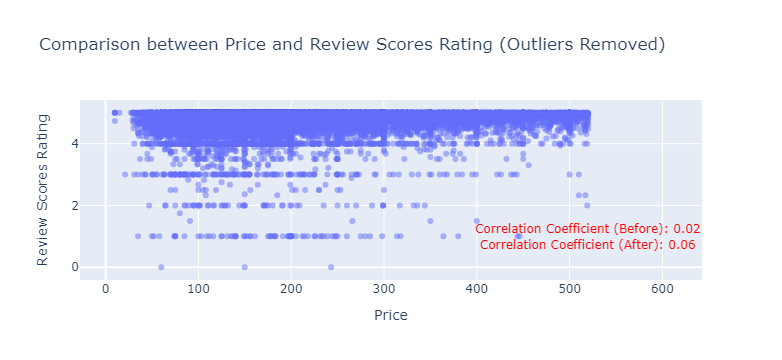

In [25]:
# Scatter plot to compare 'price' and 'review_scores_rating'
import plotly.graph_objects as go

# Calculate the correlation coefficient before removing outliers
correlation_before = listings_with_sentiment['price'].corr(listings_with_sentiment['review_scores_rating'])

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from 'price' column
listings_without_outliers = remove_outliers(listings_with_sentiment, 'price')

# Calculate the correlation coefficient after removing outliers
correlation_after = listings_without_outliers['price'].corr(listings_without_outliers['review_scores_rating'])

# Create a scatter plot using Plotly with outliers removed
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=listings_without_outliers['price'],
    y=listings_without_outliers['review_scores_rating'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=listings_without_outliers['price'].max() - .7,
    y=listings_without_outliers['review_scores_rating'].min() + 1,
    text=f'Correlation Coefficient (Before): {correlation_before:.2f}<br>Correlation Coefficient (After): {correlation_after:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Price',
    yaxis_title='Review Scores Rating',
    title='Comparison between Price and Review Scores Rating (Outliers Removed)'
)

fig.show()

## **Cost of Living**

In [27]:
cost_of_living = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/cost_of_living_us.csv')
cost_of_living.columns

Index(['case_id', 'state', 'isMetro', 'areaname', 'county',
       'family_member_count', 'housing_cost', 'food_cost',
       'transportation_cost', 'healthcare_cost', 'other_necessities_cost',
       'childcare_cost', 'taxes', 'total_cost', 'median_family_income'],
      dtype='object')

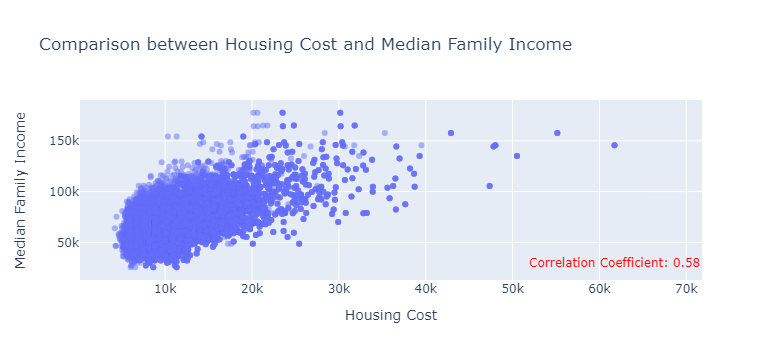

In [29]:
import plotly.graph_objects as go

# Calculate the correlation coefficient
correlation_coefficient = cost_of_living['housing_cost'].corr(cost_of_living['median_family_income'])

# Create a scatter plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=cost_of_living['housing_cost'],
    y=cost_of_living['median_family_income'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=cost_of_living['housing_cost'].max() - .7,
    y=cost_of_living['median_family_income'].min() + 5000, # Adjust position for annotation
    text=f'Correlation Coefficient: {correlation_coefficient:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Housing Cost',
    yaxis_title='Median Family Income',
    title='Comparison between Housing Cost and Median Family Income'
)

fig.show()


In [30]:
avg_cost_of_living_by_area = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/avg_cost_of_living_by_area')
avg_cost_of_living_by_area.columns

Index(['case_id', 'isMetro', 'housing_cost', 'food_cost',
       'transportation_cost', 'healthcare_cost', 'other_necessities_cost',
       'childcare_cost', 'taxes', 'total_cost', 'median_family_income',
       'adult_count', 'child_count'],
      dtype='object')

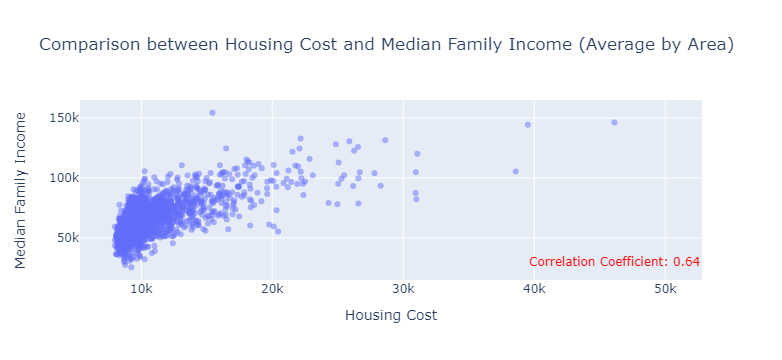

In [31]:
import plotly.graph_objects as go

# Calculate the correlation coefficient
correlation_coefficient = avg_cost_of_living_by_area['housing_cost'].corr(avg_cost_of_living_by_area['median_family_income'])

# Create a scatter plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_cost_of_living_by_area['housing_cost'],
    y=avg_cost_of_living_by_area['median_family_income'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=avg_cost_of_living_by_area['housing_cost'].max() - .7,
    y=avg_cost_of_living_by_area['median_family_income'].min() + 5000, # Adjust position for annotation
    text=f'Correlation Coefficient: {correlation_coefficient:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Housing Cost',
    yaxis_title='Median Family Income',
    title='Comparison between Housing Cost and Median Family Income (Average by Area)'
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Calculate the correlation coefficient
correlation_coefficient = avg_cost_of_living_by_area['housing_cost'].corr(avg_cost_of_living_by_area['median_family_income'])

# Create a scatter plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_cost_of_living_by_area['housing_cost'],
    y=avg_cost_of_living_by_area['median_family_income'],
    mode='markers',
    marker=dict(opacity=0.5),
    name='Scatter Plot'
))

# Add the correlation coefficient as an annotation
fig.add_annotation(
    x=avg_cost_of_living_by_area['housing_cost'].max() - .7,
    y=avg_cost_of_living_by_area['median_family_income'].min() + 5000, # Adjust position for annotation
    text=f'Correlation Coefficient: {correlation_coefficient:.2f}',
    showarrow=False,
    font=dict(color='red', size=12)
)

fig.update_layout(
    xaxis_title='Housing Cost',
    yaxis_title='Median Family Income',
    title='Comparison between Housing Cost and Median Family Income (Average by Area)'
)

fig.show()


## **Feature Engineering for Rating on each listing - STILL A WORK IN PROGRESS**

**Step 1:** Correlation Analysis and Variable Selection
- Correlation Analysis: Calculate correlations between variables, understanding the relationships between independent variables and the target variable (dependent variable).
- Variable Selection: Use methods like multiple regression, feature importance, or statistical tests to identify significant independent variables that predict the target variable.

**Step 2:** Time Series Forecasting
- Treat Variables as Time Series: Convert selected independent variables into time series data.
- Forecasting: Use methods like regression-based time series forecasting (ARIMA, SARIMA) or exponential smoothing (like Holt-Winters) to predict the next values in these time series.

**Step 3:** Incorporate Forecasts into Regression
- Generate Forecasts: Obtain forecasts for the selected independent variables.
- Feature Engineering: Use these forecasts as new features in the regression model alongside the original variables.
- Regression Modeling: Incorporate the forecasted values as features in the regression model built in Step 1 to assess if these forecasts improve prediction accuracy.

In [222]:
#checking categorical columns
cat_cols = seattle_listings_sent.select_dtypes(include = ['object'])
cat_cols.columns

Index(['last_scraped', 'name', 'description', 'neighborhood_overview',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bedrooms', 'beds', 'calendar_last_scraped', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'num_bathrooms'],
      dtype='object')

In [223]:
numerical_col = seattle_listings_sent.select_dtypes(exclude=['object'])
numerical_col.columns

Index(['id', 'latitude', 'longitude', 'accommodates', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'instant_bookable', 'listing_id',
       'avg_sentiment_score'],
      dtype='object')

### Distribution of numerical features

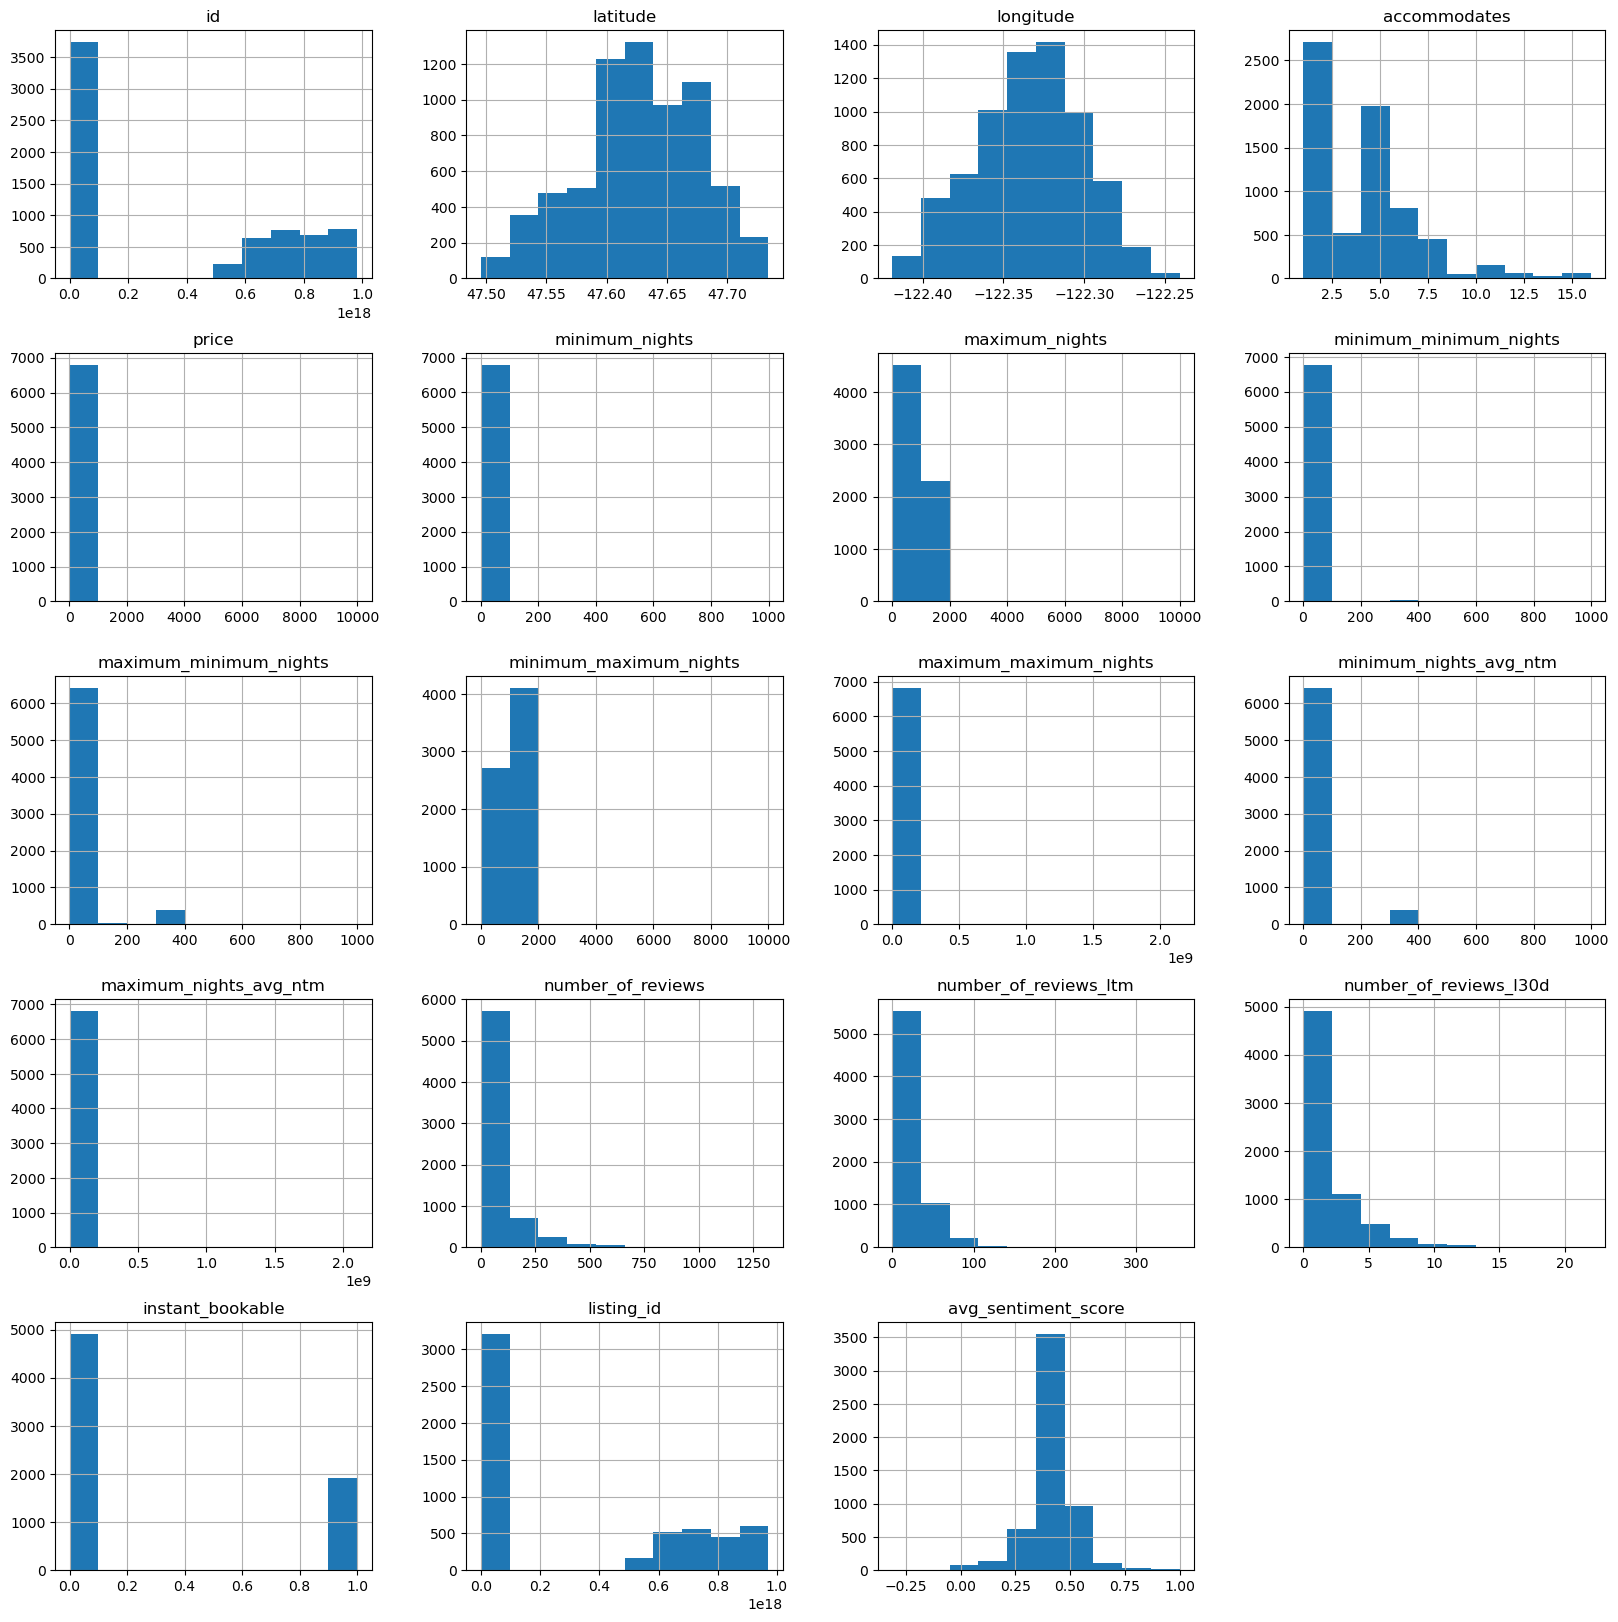

In [226]:
numerical_col.hist(figsize = (20,20))
plt.show()

### Correlations Between Features

C:\Users\12039\AppData\Local\Temp\ipykernel_34588\3274135519.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = seattle_listings_sent.corr()


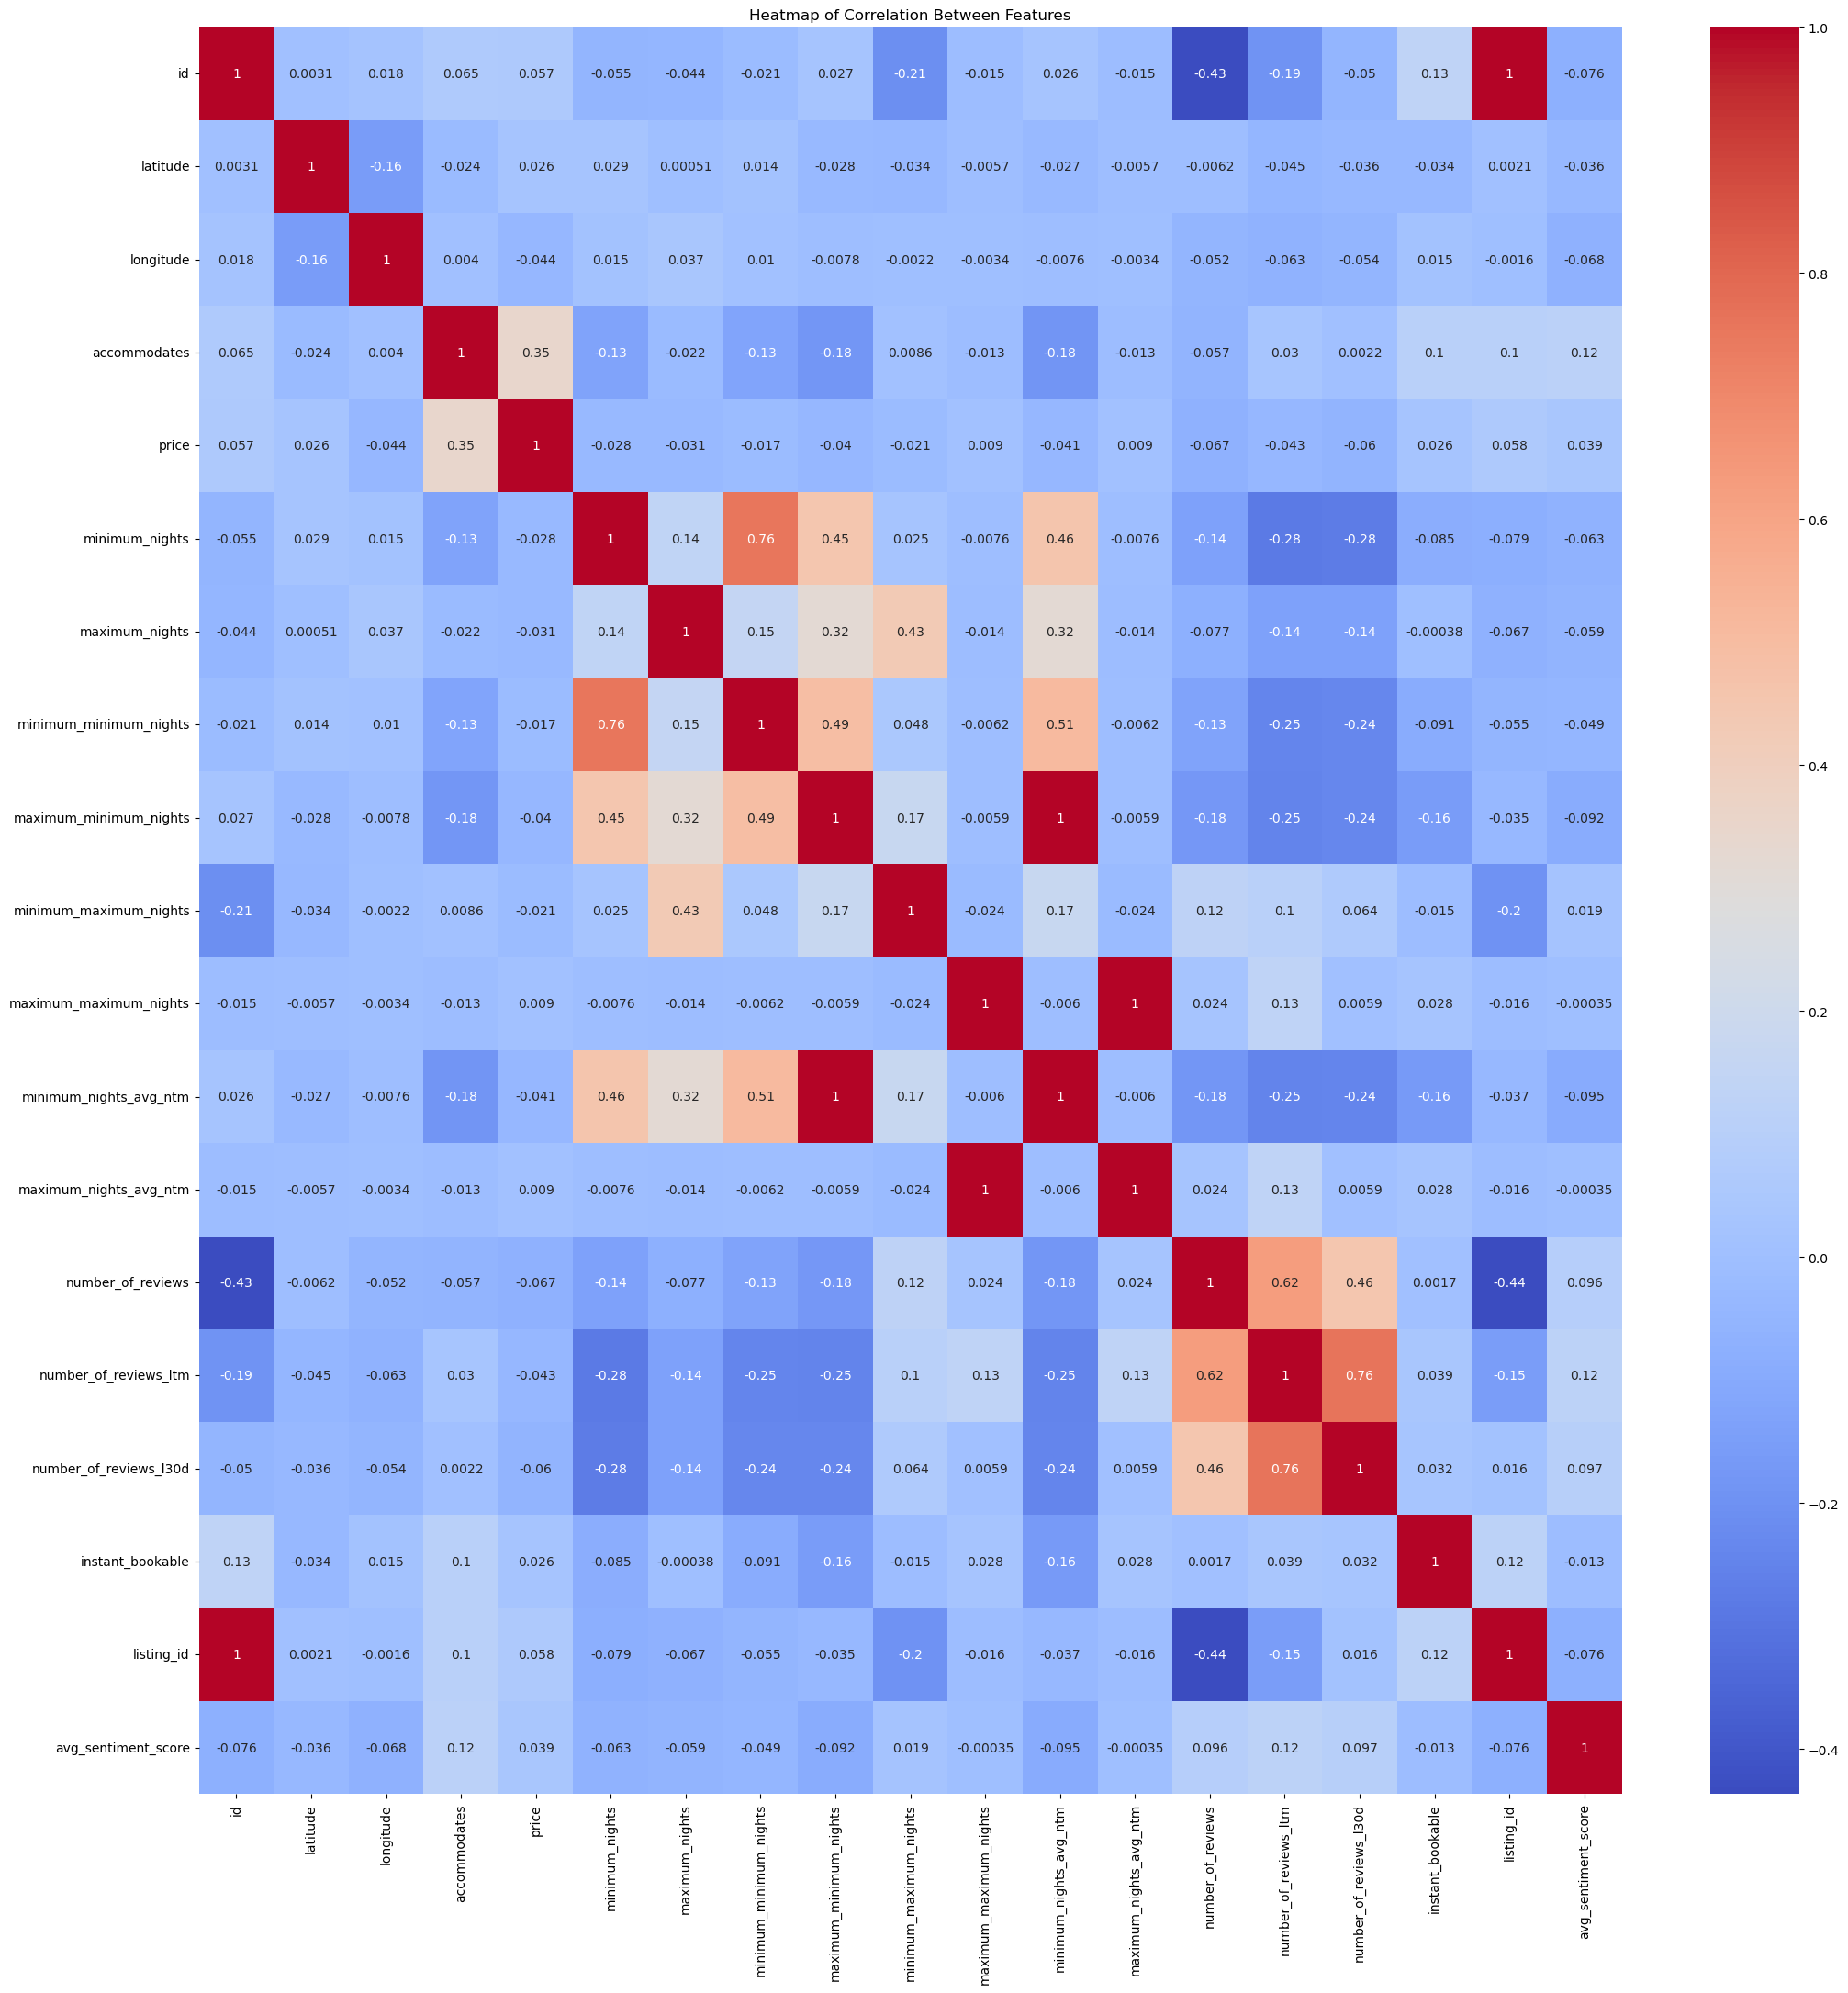

In [231]:
#  Correlations Between Features
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = seattle_listings_sent.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features");

plt.show()

In [235]:
# removing features with high correlation
# Create a correlation matrix
corr_matrix = seattle_listings_sent.corr().abs()

# Set the threshold for dropping high correlation features
threshold = 0.8

# Find the features with high correlation
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.append(colname)

# Drop the high correlation features from the DataFrame
seattle_listings_sent.drop(columns=high_corr_features, inplace=True)


C:\Users\12039\AppData\Local\Temp\ipykernel_34588\14430081.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = seattle_listings_sent.corr().abs()


In [239]:
# select relevant features for feature extraction
features = ['property_type', 'room_type', 'num_bathrooms', 'price', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

# create a new dataframe with the selected features
seattle_listings_sent_features = seattle_listings_sent[features]

In [240]:
seattle_listings_sent_features.isna().sum()

property_type                  0
room_type                      0
num_bathrooms                  0
price                          0
review_scores_rating           0
review_scores_cleanliness      0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64

In [245]:
# perform one-hot encoding on categorical data
categorical_features = ['property_type', 'room_type']
categorical_transformer = OneHotEncoder()

In [248]:
# perform feature scaling on numerical data
numerical_features = ['num_bathrooms', 'price', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
numerical_transformer = StandardScaler()

### Correlation Analysis of listing df

#function to plug df into
def plot_correlation_heatmap(df, box_size=8, font_scale=0.8, aspect=1.5):
    correlation_matrix = df.corr()
    
    plt.figure(figsize=(20, box_size))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": font_scale*10})
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(cleaned_seattle_listings)

### 1. Compute the correlation matrix: Calculate the correlation coefficients between all independent variables and the target variable (review_scores).

In [295]:
# Compute the correlation matrix
correlation_matrix = cleaned_seattle_listings.corr()

# Filter out features with 'review_scores' in their names
excluded_features = [col for col in correlation_matrix.columns if 'review_scores' in col]

# Compute the correlation of other columns with 'review_scores_rating'
correlation_with_target = correlation_matrix['review_scores_rating'].drop(excluded_features)

# Set a threshold for selecting highly correlated features
threshold = 0.1  # Modify as needed

# Identify features highly correlated with 'review_scores_rating'
highly_correlated_features = correlation_with_target[
    (correlation_with_target > threshold) | (correlation_with_target < -threshold)
].index.tolist()

# Exclude highly correlated features from the list of variables for prediction
variables_for_prediction = [
    col for col in correlation_with_target.index if col not in highly_correlated_features
]
print(highly_correlated_features)

['minimum_nights', 'maximum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month']


C:\Users\12039\AppData\Local\Temp\ipykernel_34588\2024207261.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cleaned_seattle_listings.corr()


### 2. Select variables with high correlation: Identify the variables that have a relatively high absolute correlation with the target variable.

In [291]:
threshold = 0.5
relevant_variables = target_correlation[target_correlation > threshold].index.tolist()
print(relevant_variables)

['review_scores_rating', 'review_scores_accuracy', 'review_scores_value', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location']


### Use multiple regression to identify independent variables to predict review_scores_rating

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming 'review_scores_rating' is the target variable
target_variable = 'review_scores_rating'

# Define independent variables
independent_variables = ['feature1', 'feature2', 'feature3']  # Replace with your chosen features

# Prepare data
X = cleaned_seattle_listings[independent_variables].values
y = cleaned_seattle_listings[target_variable].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
